<center> <h1> Homework 3 – Improving the Pipeline <h1> </center>
### Goal:
To improve the pipeline based on the feedback from previous assignments, and add a few components based on what we've covered in the past few lectures. More specifically, you need to:

1. Fix and improve the pipeline code you submitted for the last assignment based on the feedback from the TA. if something critical was pointed out in the feedback, you need to fix it. 

2. Add more classifiers to the pipeline on the code you've written in lab. I’d recommend at least having Logistic Regression, K-Nearest Neighbor, Decision Trees, SVM, Random Forests, Boosting, and Bagging. The code should have a parameter for running one or more of these classifiers and your analysis should run all of them.

3. Experiment with different parameters for these classifiers (different values of k for example, as well as parameters that other classifiers have). You should look at the sklearn documentation to see what parameter each classifier can take and what the default values sklearn selects.

4. Add additional evaluation metrics that we've covered in class to the pipeline (accuracy, precision at different levels, recall at different levels, F1, area under curve, and precision-recall curves).

5. Create temporal validation function in your pipeline that can create training and test sets over time. You can choose the length of these splits based on analyzing the data. For example, the test sets could be six months long and the training sets could be all the data before each test set.

Analysis:

Once you've set up the improved pipeline, you can use it to solve the problem at https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data 

The goal is to predict, at posting time of a project, if a project will not get fully funded so we can intervene and help them improve the project listing. 

The code should produce a table with results across train test splits over time and performance metrics (baseline, precision and recall at different thresholds 1%, 2%, 5%, 10%, 20%, 30%, 50% and AUC_ROC)

In [1]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
from scipy.stats import norm, lognorm
import statsmodels.api as sm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *

C:\Users\roseg\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\roseg\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\roseg\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# Supress unnecessary warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Load Data

In [3]:
def load_data(filename, verbose=False):
    df = pd.read_csv(filename, index_col=0)
    if verbose:
        print('Dataset shape:', df.shape)
        print('Dataset columns:', df.columns)
        print('Dataset types:', df.dtypes)
        print('')
    return df

In [4]:
projects = load_data('data/projects.csv')

In [5]:
outcomes = load_data('data/outcomes.csv')

In [6]:
projects['fully_funded'] = outcomes['fully_funded']

In [7]:
projects['date_posted'] = projects['date_posted'].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d"))

In [8]:
df = projects[(projects['date_posted'].dt.year >= 2011) & (projects['date_posted'].dt.year <= 2013)]

In [9]:
df.head()

,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,...,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted,fully_funded
projectid,,,,,,,,,,,,,,,,,,,,,
62526d85d2a1818432d03d600969e99c,ebc7c90b6c92a069432e0714b8d93dfd,5aca9711ff0e4b37db48701f46f73036,1.713710e+11,41.972419,-88.174597,Bartlett,IL,60103.0,suburban,Elgin School District U-46,...,moderate poverty,Grades 3-5,30.0,444.36,522.78,7.0,f,f,2013-12-31,t
33d59ac771b80222ad63ef0f4ac47ade,de83b4c1f6428a15032c207c1d5e572a,d91a805b213bf74ae77b94e0de2b73ad,1.601530e+11,43.501154,-112.056780,Idaho Falls,ID,83402.0,urban,Idaho Falls School District 91,...,high poverty,Grades 3-5,30.0,233.24,274.40,30.0,f,f,2013-12-31,f
1a3aaeffc56dd2a421e37d8298024c0a,f4c9ed095b85458dcf858e25f203af00,9310d3eb447a4e46bc5fc31ed007ceac,3.302610e+11,42.888244,-71.320224,Derry,NH,3038.0,suburban,School Administrative Unit 10,...,moderate poverty,Grades 6-8,30.0,285.09,335.40,230.0,f,f,2013-12-31,f
33aa19ee4da4c5adf47d0dfb84fab5ef,17768031eb40de8d4497dbb54df48742,9ac70da58322783f82152eecc140a812,5.103240e+11,37.476158,-77.488397,Richmond,VA,23224.0,urban,Richmond City School District,...,highest poverty,Grades PreK-2,30.0,232.94,274.05,18.0,f,f,2013-12-31,f
e31c0ea8b68f404699dfb0d39e9bc99b,0f1bc5b4700fd33383be104442660178,cb9f688cf59e3ee22a087d616ca8f5d7,1.709930e+11,41.952851,-87.650233,Chicago,IL,60613.0,urban,Ravenswood-ridge Elem Network,...,highest poverty,Grades 6-8,30.0,513.41,604.01,70.0,t,f,2013-12-31,t


## 2. Explore Data

#### Check Correlation

In [10]:
def create_correlation_heatmap(df):
    # compute correlation matrix
    corr = df.corr()
    
    # generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # create figure and plot
    fig = plt.figure(figsize=(len(cont_feats), 5)) 
    sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap=sns.diverging_palette(220, 10, as_cmap=True))
    plt.show()

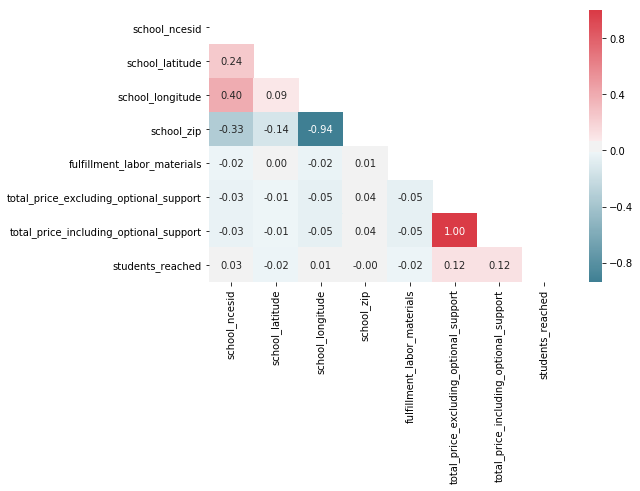

In [11]:
cont_feats = list(df.describe())
create_correlation_heatmap(df)

## 3. Pre-Process and Clean Data

#### Drop columns

In [12]:
df.columns

Index(['teacher_acctid', 'schoolid', 'school_ncesid', 'school_latitude',
       'school_longitude', 'school_city', 'school_state', 'school_zip',
       'school_metro', 'school_district', 'school_county', 'school_charter',
       'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp',
       'school_charter_ready_promise', 'teacher_prefix',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level', 'fulfillment_labor_materials',
       'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted', 'fully_funded'],
      dtype='object')

In [13]:
df = df.drop(columns=['teacher_acctid', 'schoolid', 'school_ncesid', 'school_latitude', 'school_longitude',
                 'school_city', 'school_state', 'school_zip', 'school_district'])

#### Convert 'fully_funded' from t/f to 1/0

In [14]:
def convert_str_to_binary(binary_cols):
    for i in binary_cols:
        if df[i].dtype != 'int32':
            df[i] = np.where((df[i] == 't'), 1, 0)

In [15]:
binary_cols = ['school_county', 'school_charter', 'school_magnet', 'school_year_round',
               'school_nlns', 'school_kipp', 'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
               'eligible_double_your_impact_match', 'eligible_almost_home_match', 'fully_funded']

convert_str_to_binary(binary_cols)

#### Convert Categorical Features to Binary Features

In [16]:
def one_hot_encoding_categorical(df):
    # separate out categorical features
    cat_feats = [x for x in df.select_dtypes(include=['object']).columns]
    print(cat_feats)
    
    # one hot encoding for categorical features
    binary_feats = pd.get_dummies(df[cat_feats])

    # concatenate binary features
    df = pd.concat([df, binary_feats], axis=1)
    df = df.drop(cat_feats, axis=1)
    return df

In [17]:
df = one_hot_encoding_categorical(df)

['school_metro', 'school_charter_ready_promise', 'teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 'secondary_focus_subject', 'secondary_focus_area', 'resource_type', 'poverty_level', 'grade_level']


#### Check for NAs

In [18]:
print('% of rows with missing values:', round(len(df[df.isnull().any(axis=1)])/len(df),5)*100)

% of rows with missing values: 0.029


In [19]:
print('Columns with missing values:', df.columns[df.isnull().any()].tolist())

Columns with missing values: ['students_reached']


#### Fill NAs

In [20]:
def fill_na_with_zero(df):
    df2 = df.copy(deep=True)
    null_vars = list(df2.columns[df2.isnull().any()])
    for i in null_vars:
        df2[i] = df2[i].fillna(0)
    return df2

In [21]:
df = fill_na_with_zero(df)

#### Outlier Detection

In [22]:
def iqr_outlier(var):
    q1, q3 = np.percentile(var, [25, 75])
    iqr = q3 - q1
    lower_fence = q1 - (iqr * 1.5)
    upper_fence = q3 + (iqr * 1.5)
    return np.where((var > upper_fence) | (var < lower_fence))

In [23]:
check_outliers_columns = ['fulfillment_labor_materials', 'total_price_excluding_optional_support',
                          'total_price_including_optional_support', 'students_reached', 'fully_funded']

In [24]:
for i in check_outliers_columns:
    print(iqr_outlier(df[i]))

(array([], dtype=int64),)
(array([    33,     46,     47, ..., 353081, 353089, 353109], dtype=int64),)
(array([    33,     46,     47, ..., 353081, 353089, 353109], dtype=int64),)
(array([     2,     38,     47, ..., 353118, 353136, 353139], dtype=int64),)
(array([], dtype=int64),)


In [25]:
def histogram(df, column, bins, xmin, xmax, ymin, ymax):
    '''
    Create histogram of variable
    '''
    plt.figure(figsize=(9,5))
    n, bins, patches = plt.hist(df[column], bins=bins, alpha=0.75, color='grey')
    
    # plot histogram
    plt.xlabel(column)
    plt.ylabel('Probability')
    plt.title('Histogram of ' + column)
    plt.axis([xmin, xmax, ymin, ymax])
    plt.grid(True)
    plt.show()   

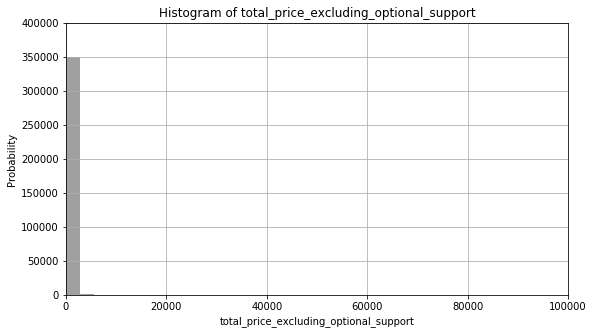

In [27]:
histogram(df, 'total_price_excluding_optional_support', bins=50, xmin=0, xmax=100000, ymin=0, ymax=400000)

Let's try taking the log.

In [28]:
def create_log_column(df, column, bins, xmin, xmax, ymin, ymax):
    # fit the normal distribution on log target
    mu, sigma = norm.fit(np.log(df[column]))

    # create histogram of log column
    plt.figure(figsize=(7,5))
    n, bins, patches = plt.hist(np.log(df[column]), bins=bins, normed=True, alpha=0.75, color='Grey')

    # add fitted line
    y = mlab.normpdf(bins, mu, sigma)
    l = plt.plot(bins, y, 'g--', linewidth=2)

    # plot histogram
    plt.xlabel('Log {}'.format(column))
    plt.ylabel('Probability')
    plt.title('Histogram of Log {}: mu = {}, sigma = {}'.format(column, round(mu, 2), round(sigma, 2)))
    plt.axis([xmin, xmax, ymin, ymax])
    plt.grid(True)
    plt.show()

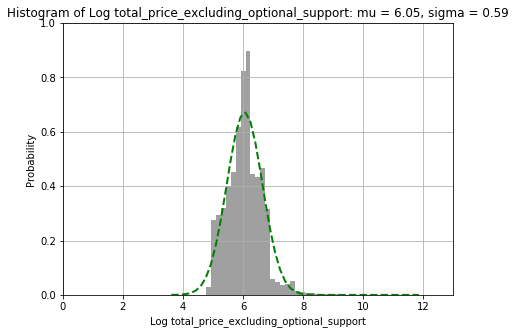

In [29]:
create_log_column(df, 'total_price_excluding_optional_support', bins=50, xmin=0, xmax=13, ymin=0, ymax=1)

In [30]:
def log_column(df, column):
    df[column] = np.log(df[column])
    df = df.drop(columns=column)
    return df

In [31]:
df = log_column(df, 'total_price_excluding_optional_support')

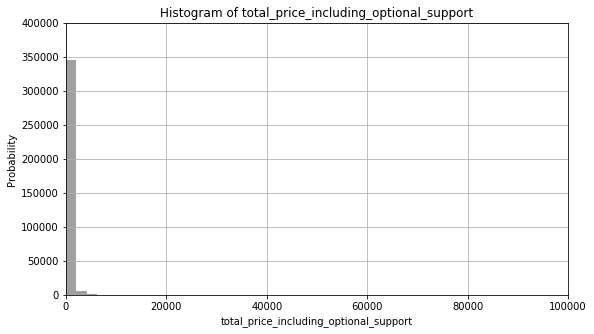

In [32]:
histogram(df, 'total_price_including_optional_support', bins=80, xmin=0, xmax=100000, ymin=0, ymax=400000)

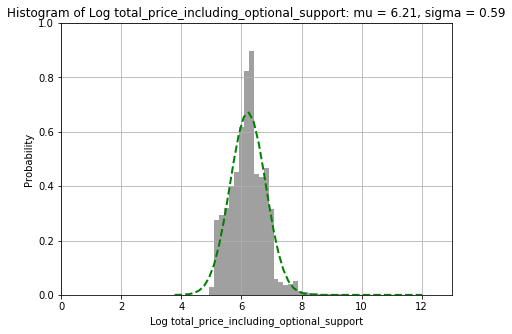

In [33]:
create_log_column(df, 'total_price_including_optional_support', bins=50, xmin=0, xmax=13, ymin=0, ymax=1)

In [34]:
df = log_column(df, 'total_price_including_optional_support')

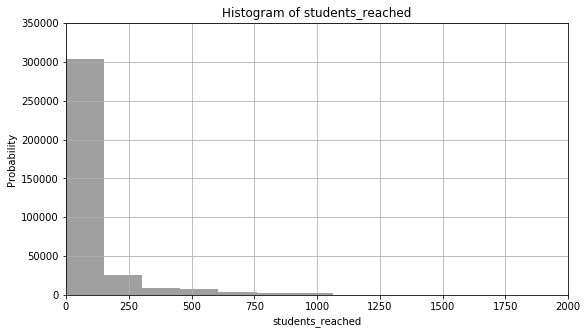

In [35]:
histogram(df, 'students_reached', bins=80, xmin=0, xmax=2000, ymin=0, ymax=350000)

In [36]:
# add one so that I can take the log of this column
df['students_reached'] += 1

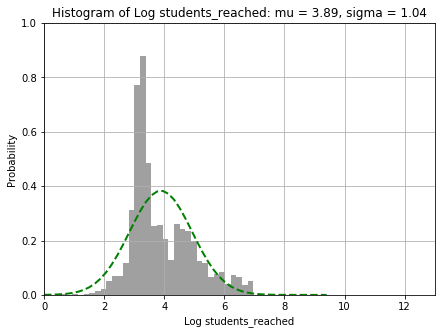

In [37]:
create_log_column(df, 'students_reached', bins=50, xmin=0, xmax=13, ymin=0, ymax=1)

In [38]:
df = log_column(df, 'students_reached')

### 4. Generate Features/Predictors

#### Convert Datetime Feature to Numeric Features

In [39]:
df['weekday'] = df['date_posted'].dt.dayofweek
df['week'] = df['date_posted'].dt.weekofyear

### 5. Build Machine Learning Classifiers

Logistic Regression, K-Nearest Neighbor, Decision Trees, SVM, Random Forests, Boosting, and Bagging

In [48]:
clfs = {'LR': LogisticRegression(), 
        'KNN': KNeighborsClassifier(),
        'DT': DecisionTreeClassifier(), 
        'SVM': svm.SVC(), 
        'RF': RandomForestClassifier(), 
        'AB': AdaBoostClassifier(),
        'BAG': BaggingClassifier()}
    
grid = {'LR': { 'penalty': ['l1','l2'], 'C': [0.01,0.1,1,10]},
        'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform', 'distance'], 'algorithm': ['auto','ball_tree','kd_tree']},
        'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100],'min_samples_split': [2,5,10]},
        'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
        'RF':{'n_estimators': [10,100], 'max_depth': [5,25], 'max_features': ['sqrt','log2'],'min_samples_split': [5,10], 'n_jobs': [-1]},
        'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000]},
        'BAG': {}}

### 6. Create Temporal Train/Test Sets

In [41]:
def temporal_train_test_split(df, time_col, period=None):
    '''
    Creates temporal train/test splits.
    Inputs: 
        df
        time_col (str): name of time column
        period (str of the format '1M', '3M', '6M', etc.): how long the 
            testing period should be
    Returns:
        test_dfs: list of test dfs
        train_dfs: list of training dfs
        times: list of start times indexed to test and train lists
    '''
    time_starts = pd.date_range(start = df[time_col].min(), 
                                end = df[time_col].max(), freq = period)
    times = []
    train_sets = []
    test_sets = []

    for i, time in enumerate(time_starts[:-1]):
        time_split = time + pd.DateOffset(1)
        train_mask = (df[time_col] <= time)
        test_mask = (df[time_col] > time_split) & (df[time_col] < time_starts[i+1])
        
        train = df.loc[train_mask]
        train = train.drop(columns=time_col)
        test = df.loc[test_mask]
        test = test.drop(columns=time_col)

        train_sets.append(train)
        test_sets.append(test)
        times.append(time)
        
    return train_sets, test_sets, times

In [42]:
train_sets, test_sets, times = temporal_train_test_split(df, 'date_posted', period='6M')

### 7. Build Classifiers

In [43]:
def plot_precision_recall(y_true, y_prob, model_name):
    """Adopted from: https://github.com/rayidghani/magicloops/blob/master/magicloops.py"""
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)

    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)

    pct_above_per_thresh = np.array(pct_above_per_thresh)
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax1.set_ylim([0,1])
    ax1.set_ylim([0,1])
    ax2.set_xlim([0,1])
    
    plt.title(model_name)
    plt.show()

In [44]:
def precision_at_k(y_true, y_scores, k):
    idx = np.argsort(np.array(y_scores))[::-1]
    y_scores, y_true = np.array(y_scores)[idx], np.array(y_true)[idx]
    cutoff_index = int(len(y_scores) * (k / 100.0))
    preds_at_k = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    precision = precision_score(y_true, preds_at_k)
    return precision

In [45]:
def clfs_loop(models, clfs, grid, X_train, X_test, y_train, y_test, plot=True):
    """
    Runs each model in models and calculates the AUC-ROC score, 
    calculates precision at 1%, 5%, 10%, 20%, 30%, and 50%,
    and plots the precision-recall curve.
    Inputs:
        models
        clfs
        grid
        X
        y
        plot
    Returns: results_df: a DataFrame of results
    """
    results_df =  pd.DataFrame(columns=('model_type', 'clf', 'parameters', 'auc-roc',
                                        'p_at_1', 'p_at_2', 'p_at_5',
                                        'p_at_10', 'p_at_20', 'p_at_30', 'p_at_50'))
        
    for i, clf in enumerate([clfs[m] for m in models]):
        print(models[i])
        params = grid[models[i]]
        for p in ParameterGrid(params):
            try:
                clf.set_params(**p)
                y_pred_probs = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
                y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))
                results_df.loc[len(results_df)] = [models[i], clf, p,
                                                   roc_auc_score(y_test, y_pred_probs),
                                                   precision_at_k(y_test_sorted,y_pred_probs_sorted,1.0),
                                                   precision_at_k(y_test_sorted,y_pred_probs_sorted,2.0),
                                                   precision_at_k(y_test_sorted,y_pred_probs_sorted,5.0),
                                                   precision_at_k(y_test_sorted,y_pred_probs_sorted,10.0),
                                                   precision_at_k(y_test_sorted,y_pred_probs_sorted,20.0),
                                                   precision_at_k(y_test_sorted,y_pred_probs_sorted,30.0),
                                                   precision_at_k(y_test_sorted,y_pred_probs_sorted,50.0)]
                if plot:
                    plot_precision_recall(y_test, y_pred_probs, clf)
        
            except IndexError as e:
                print('Error:', e)
                continue
    return results_df

## 8. Evaluate Models

In [46]:
def clfs_loop_temporal(train_sets, test_sets, models):
    for i in range(len(train_sets)):
        train = train_sets[i]
        test = test_sets[i]

        y_train = train['fully_funded']
        X_train = train.drop(columns='fully_funded')
        y_test = test['fully_funded']
        X_test = test.drop(columns='fully_funded')

        results = clfs_loop(models, clfs, grid, X_train, X_test, y_train, y_test)
        print(results)

LR


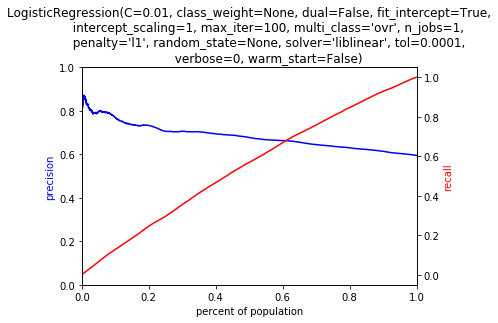

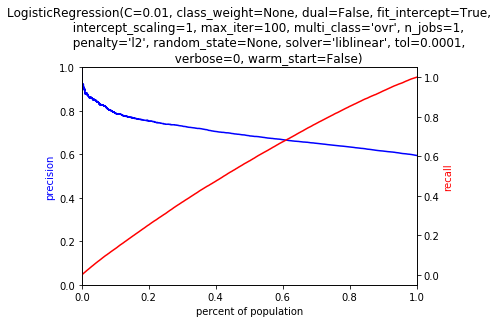

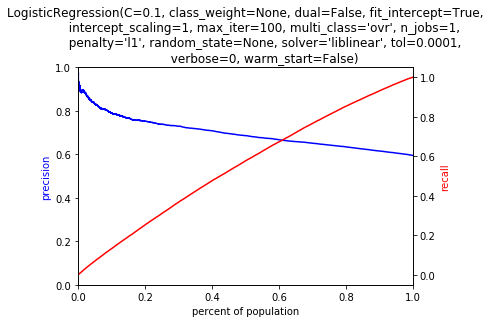

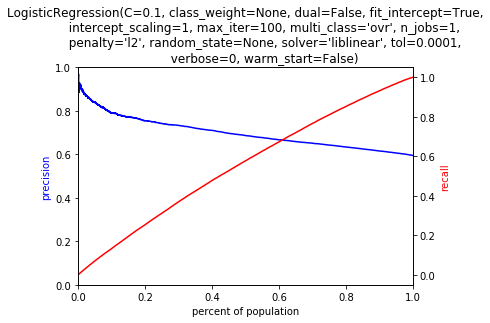

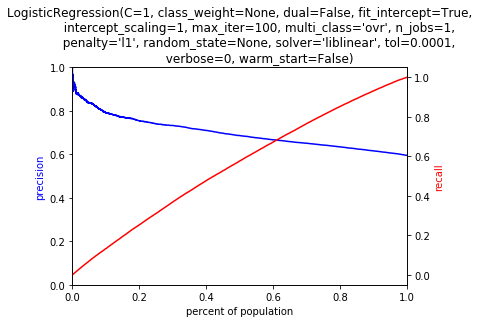

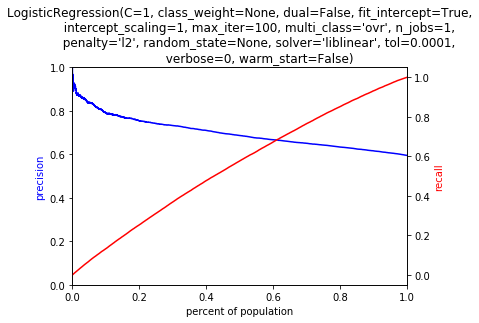

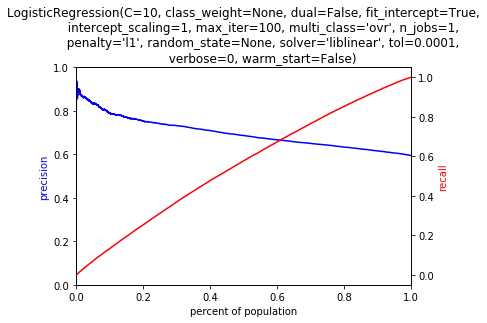

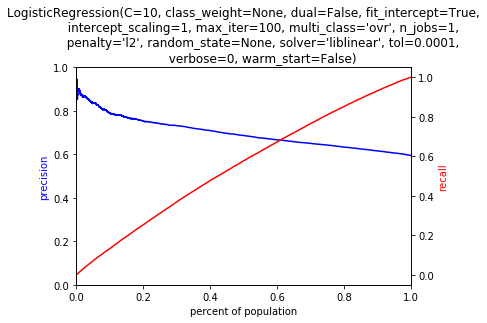

KNN


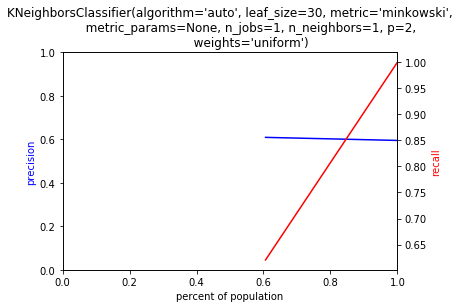

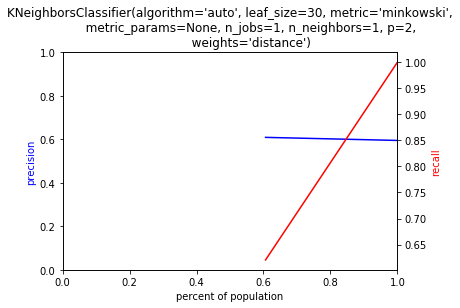

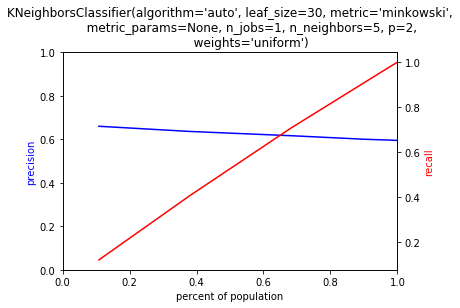

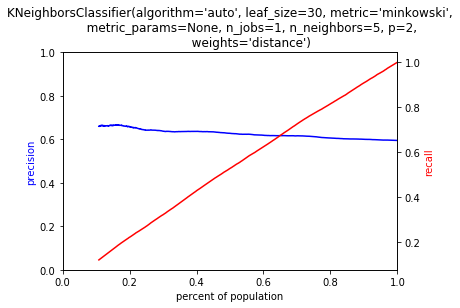

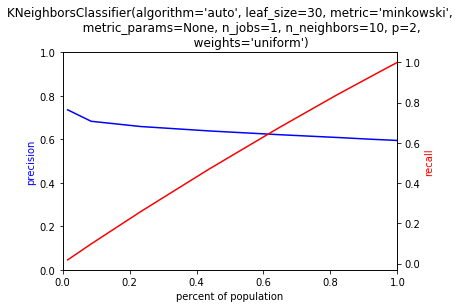

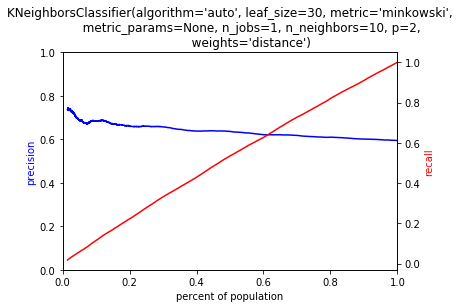

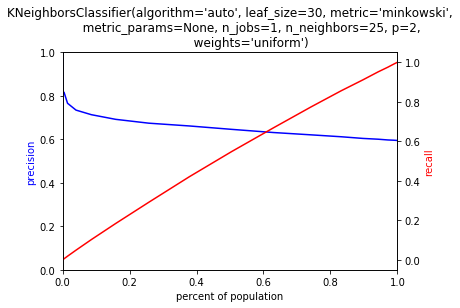

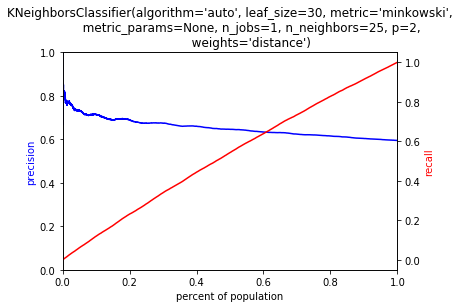

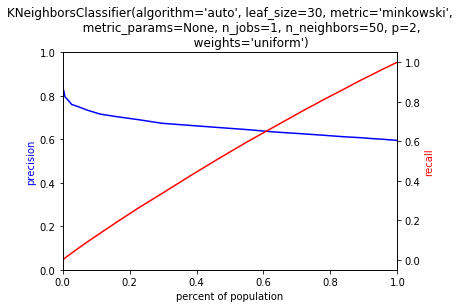

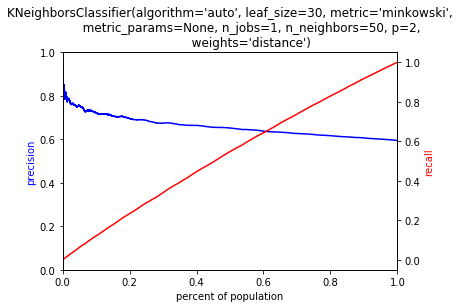

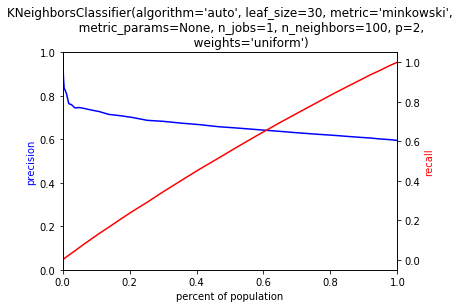

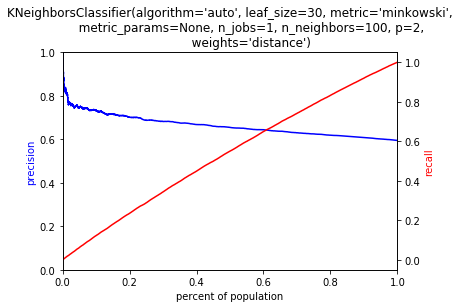

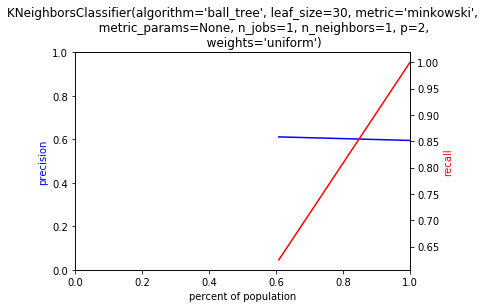

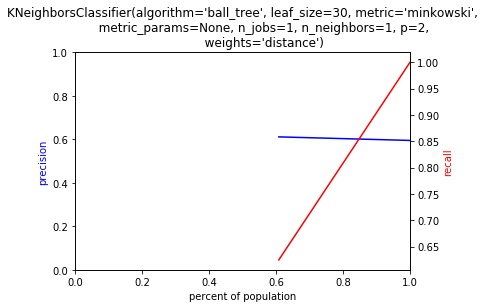

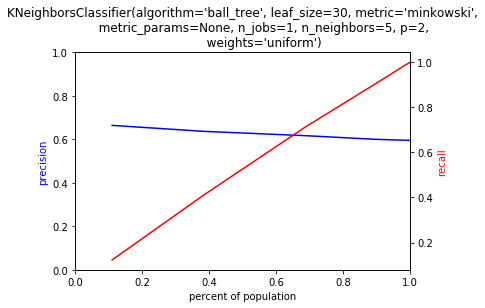

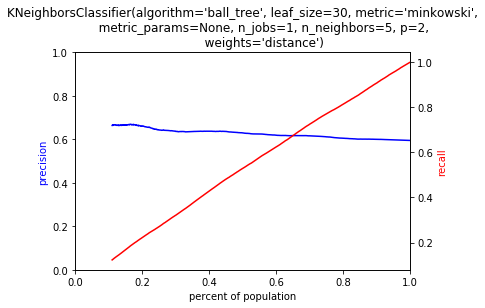

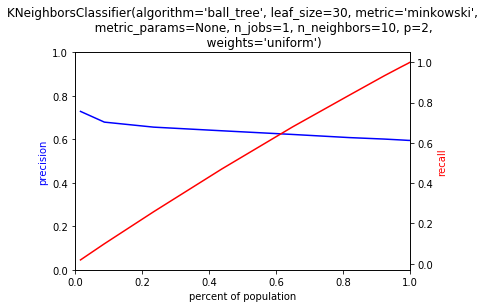

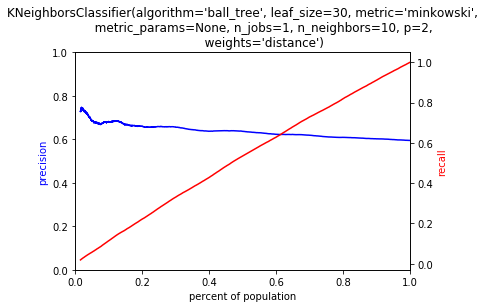

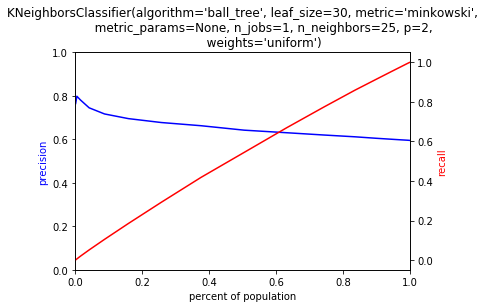

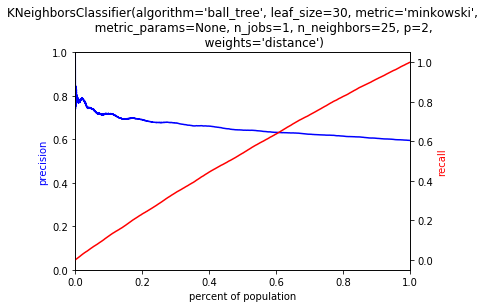

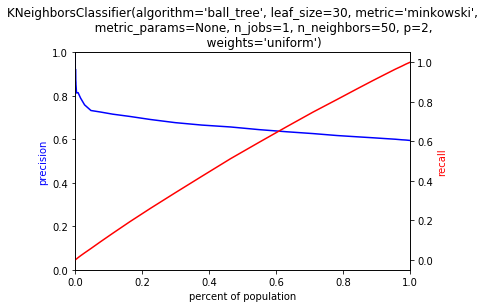

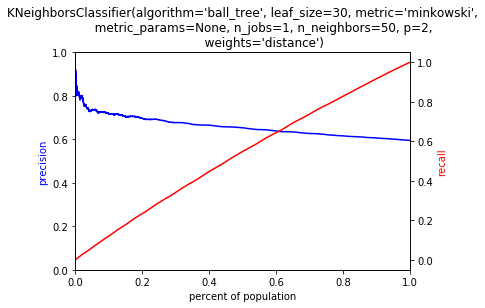

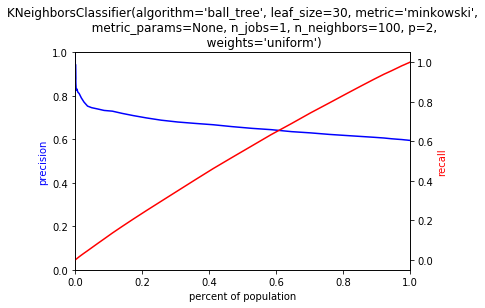

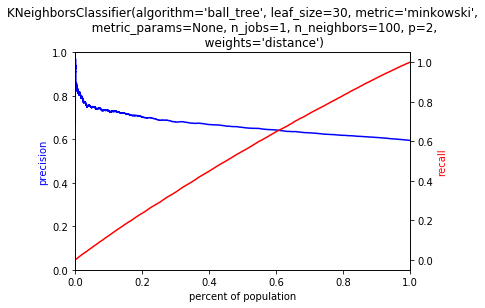

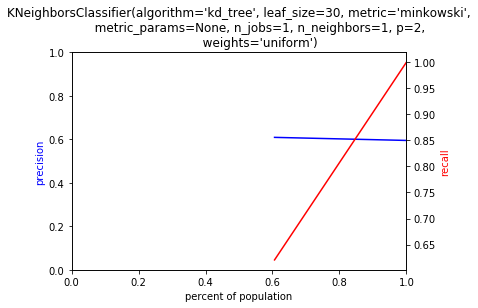

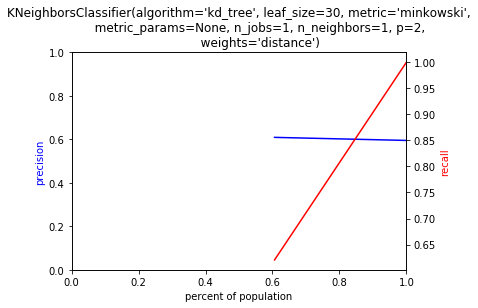

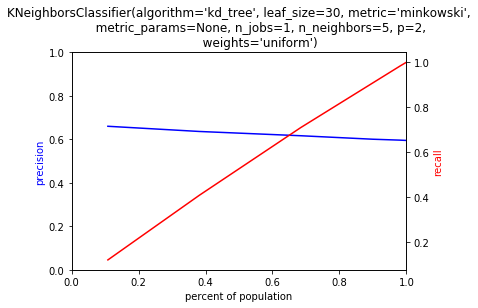

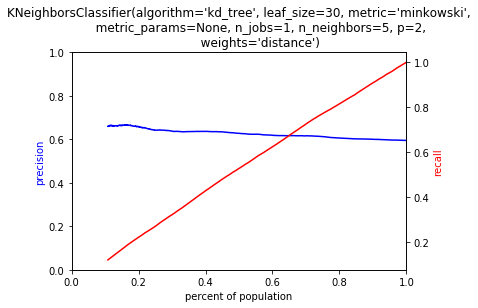

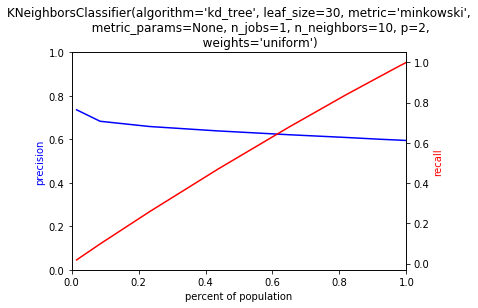

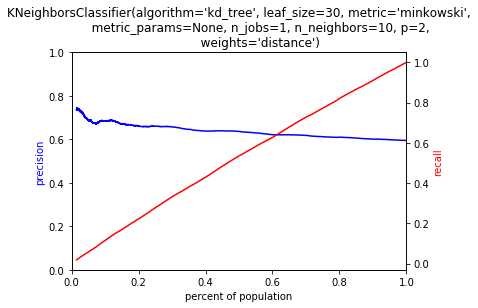

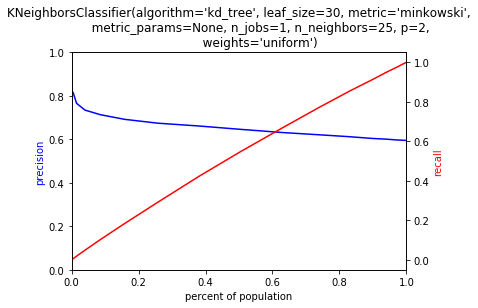

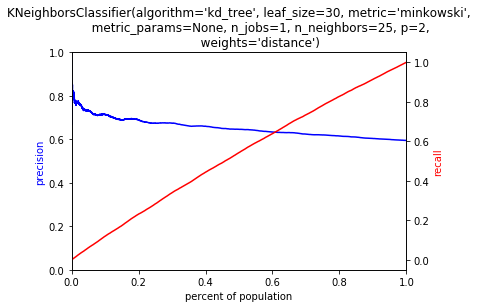

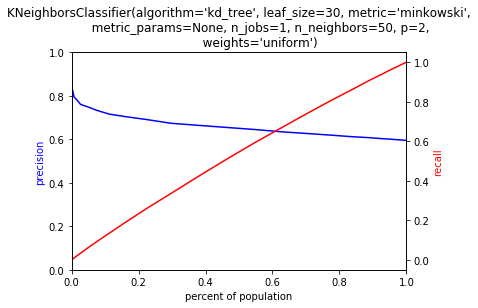

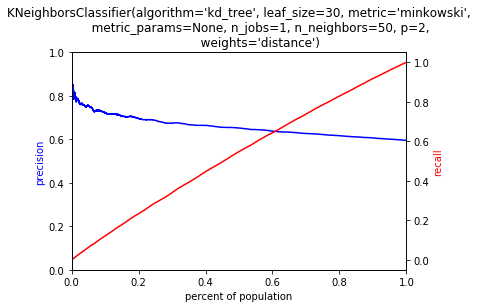

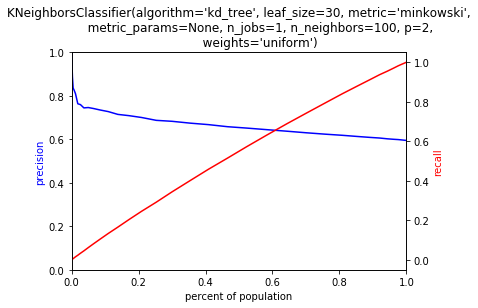

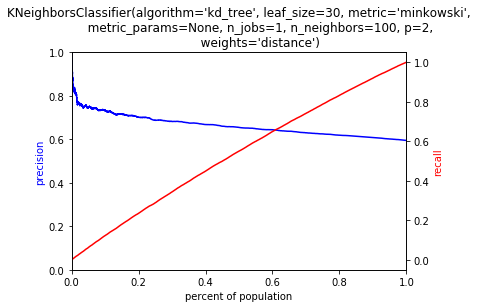

DT


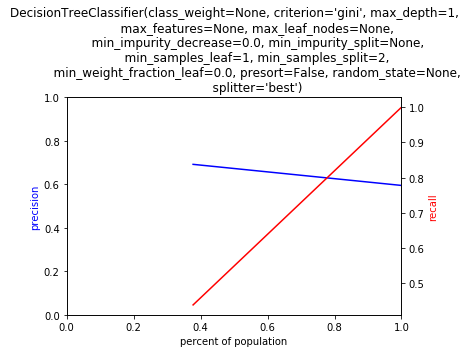

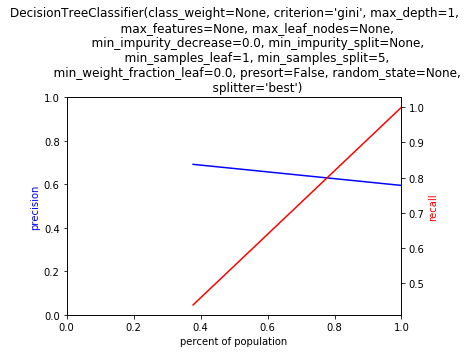

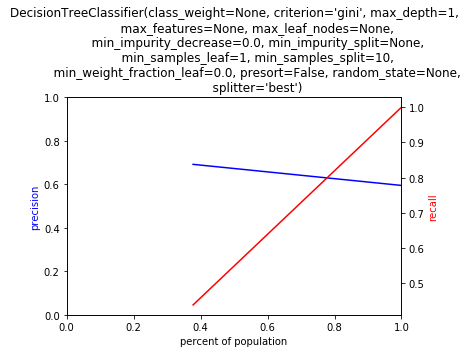

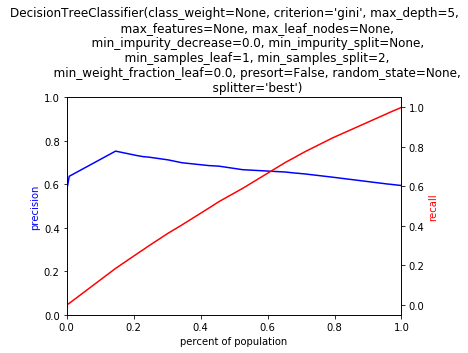

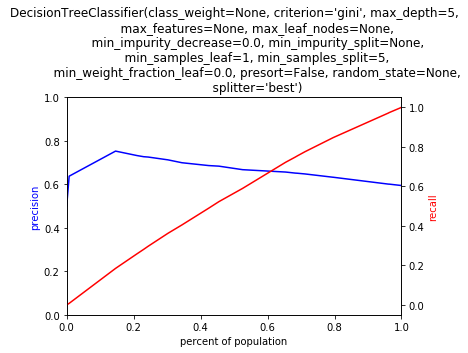

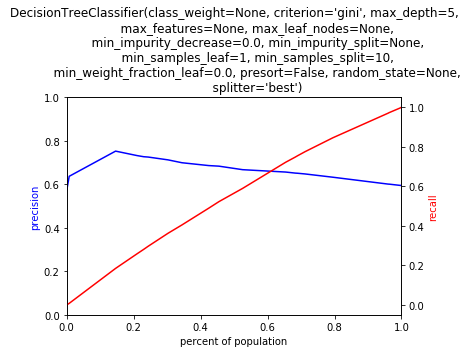

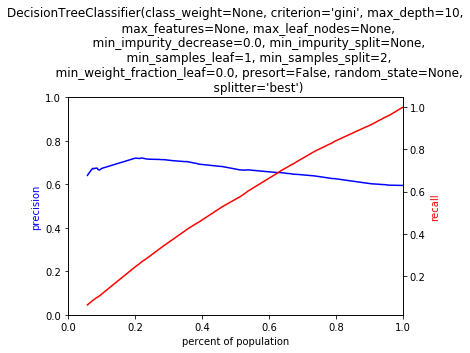

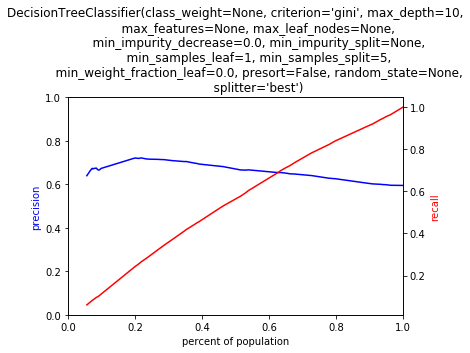

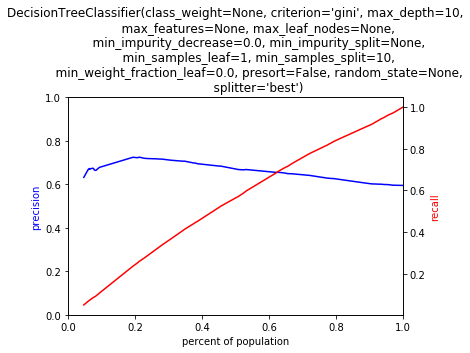

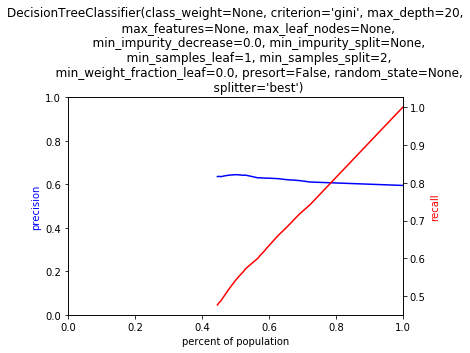

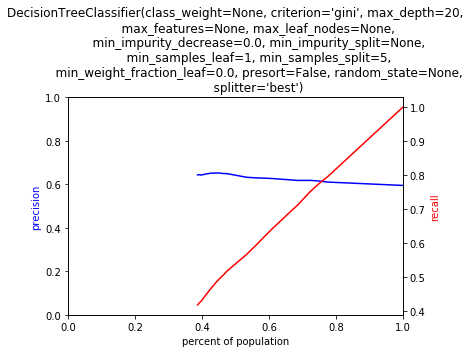

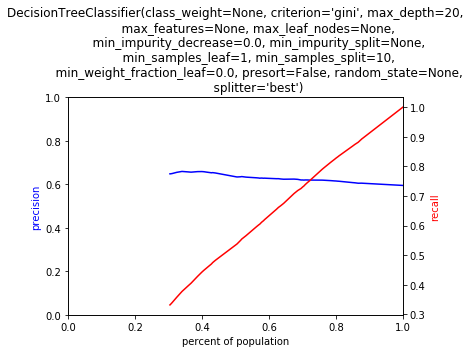

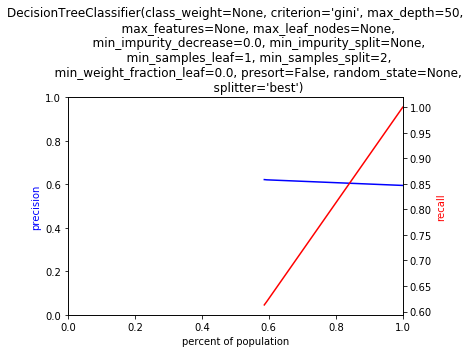

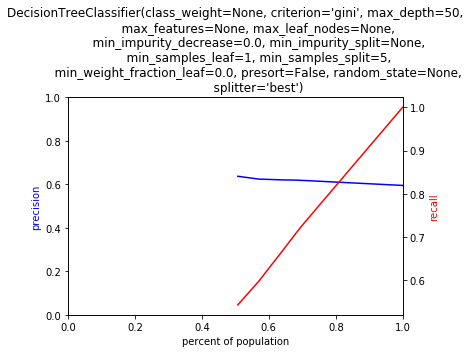

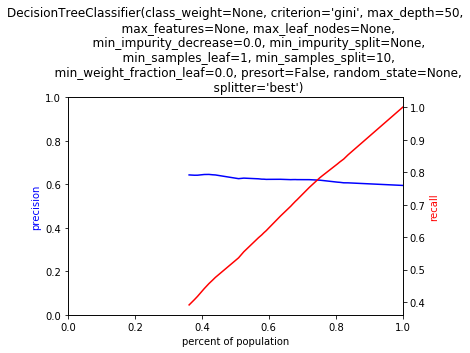

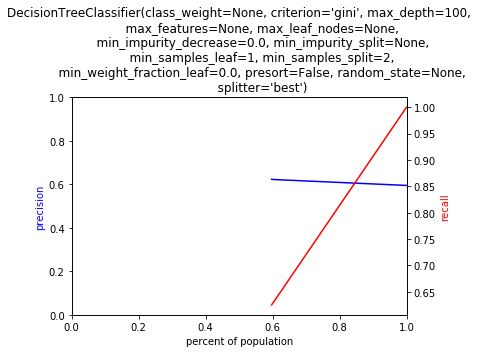

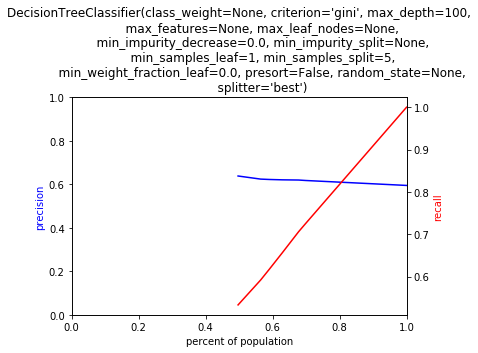

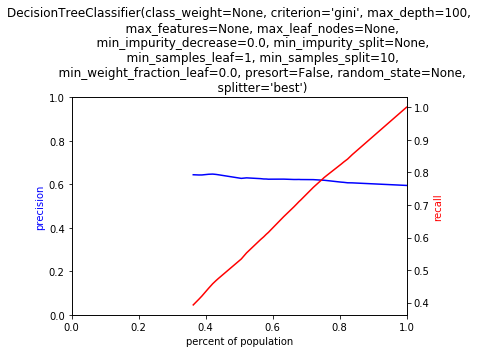

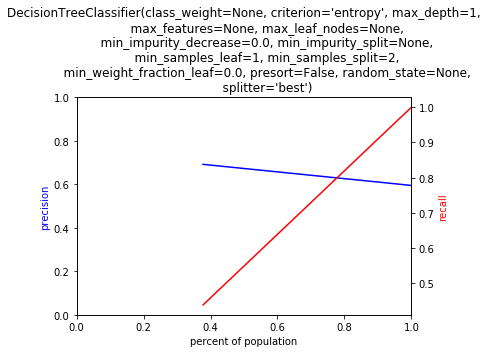

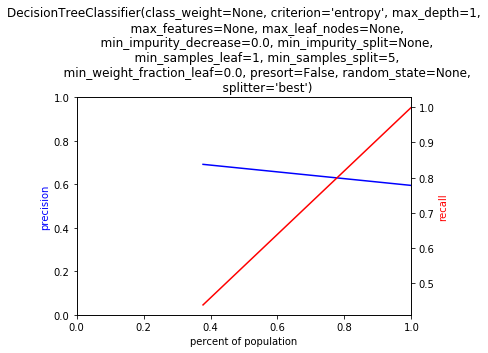

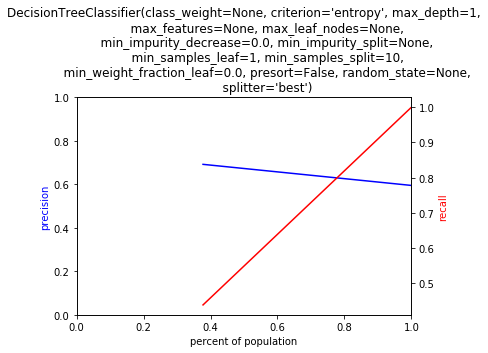

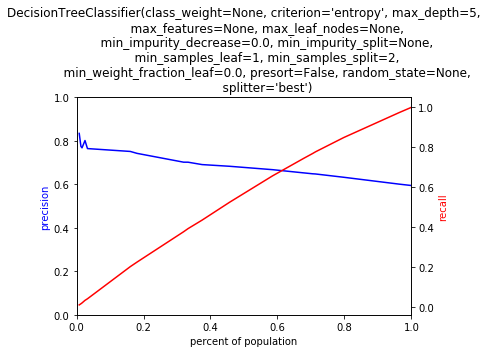

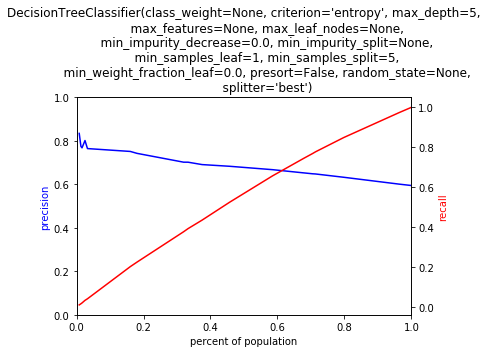

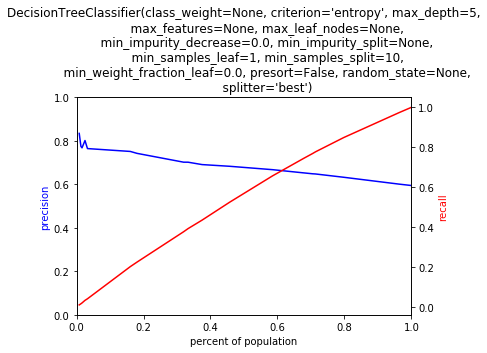

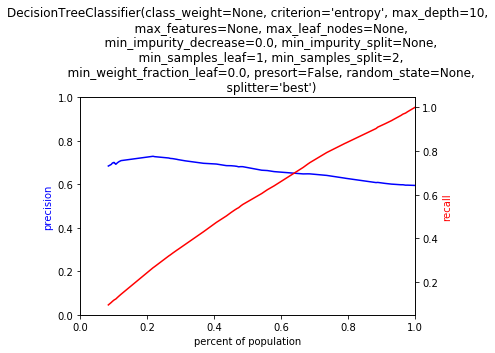

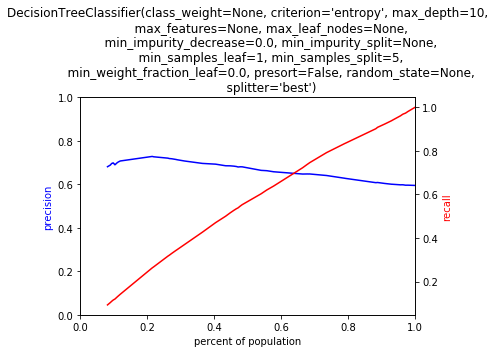

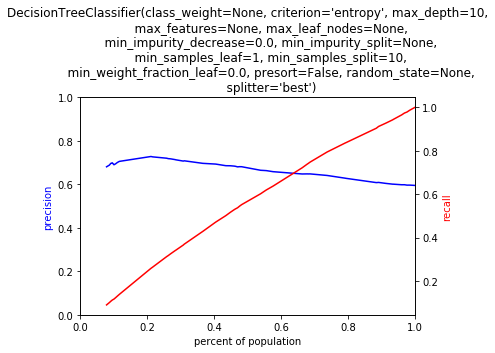

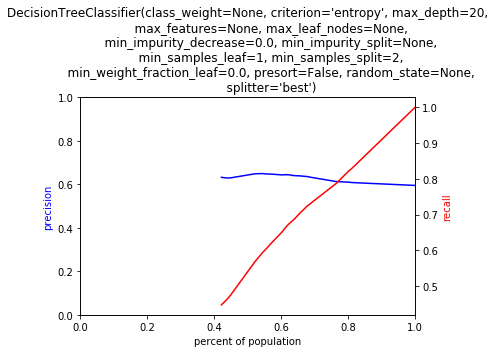

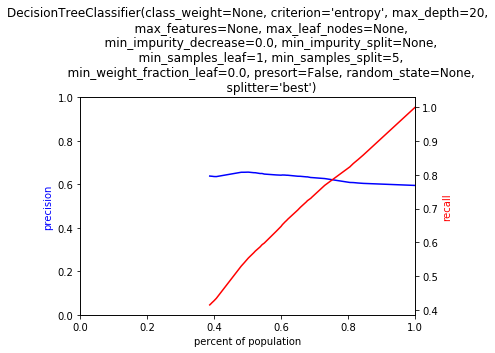

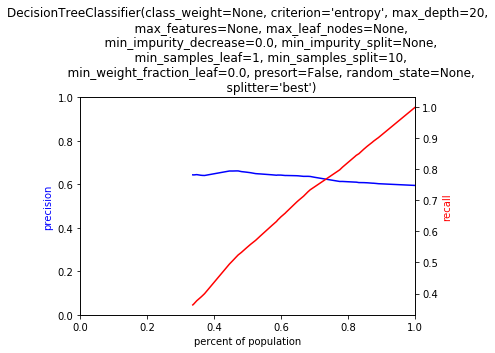

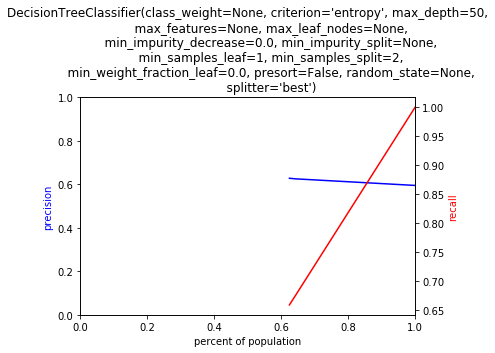

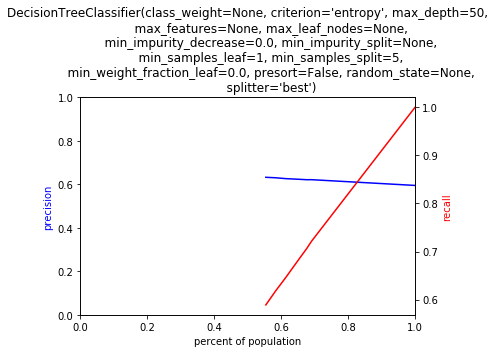

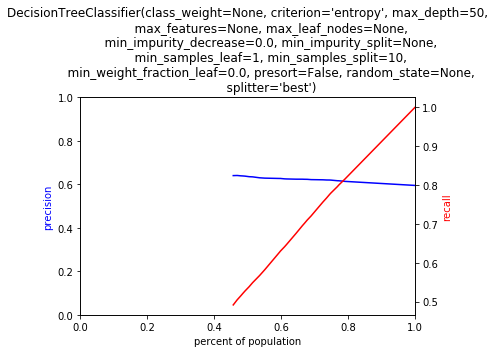

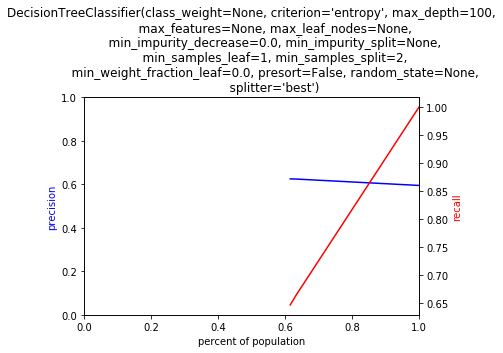

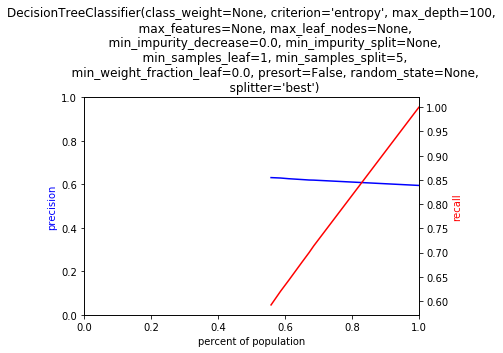

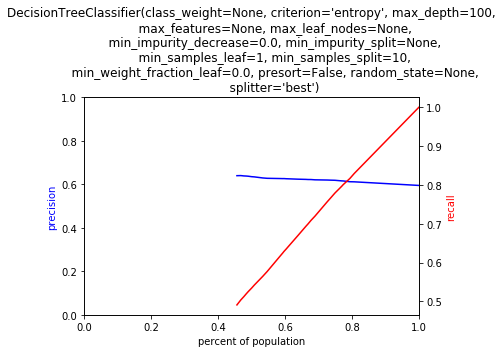

RF


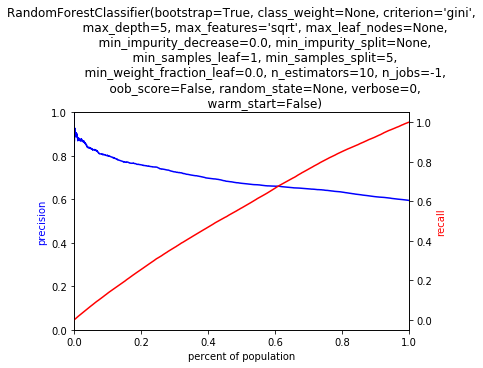

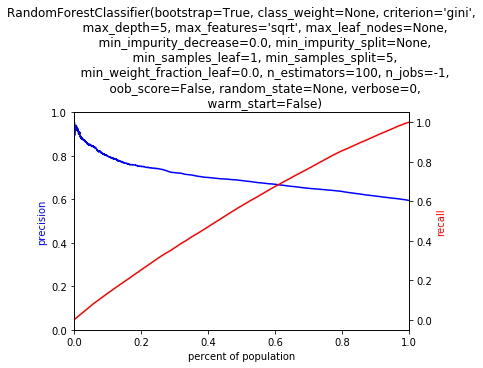

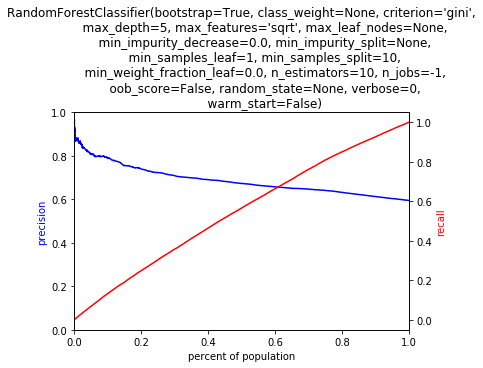

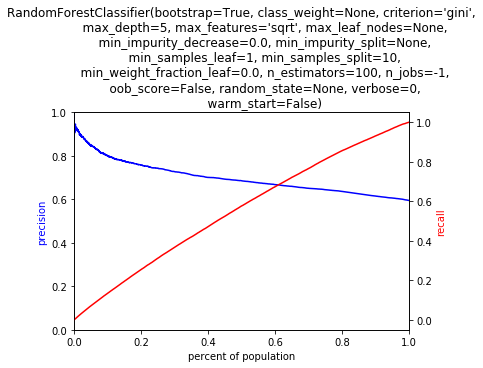

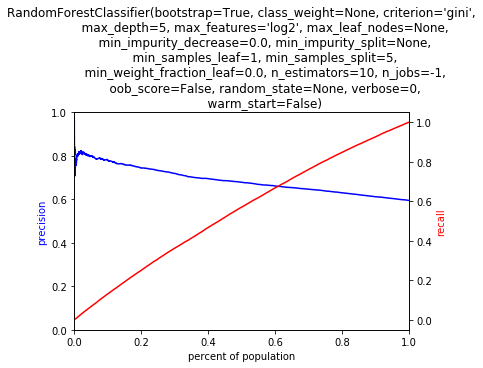

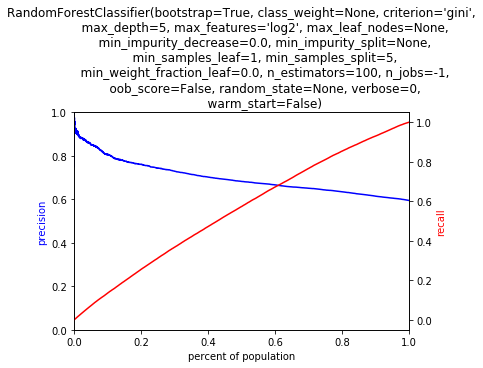

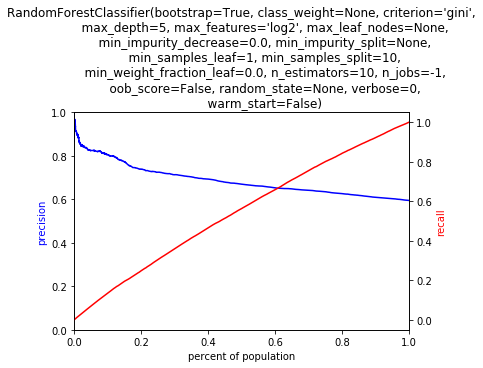

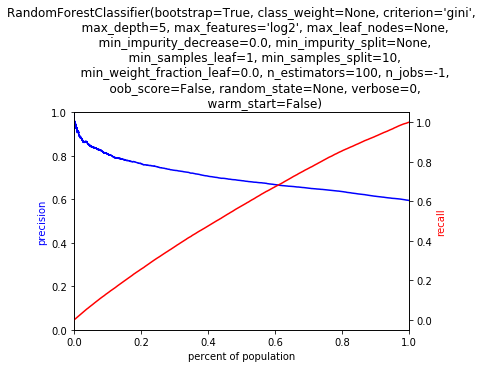

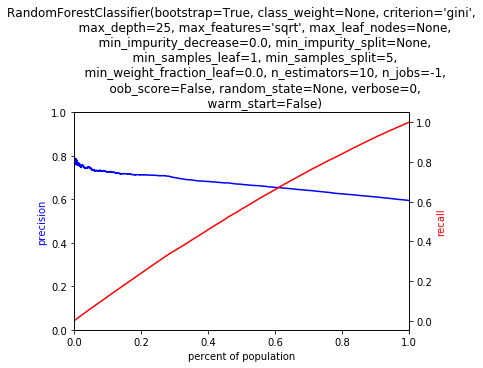

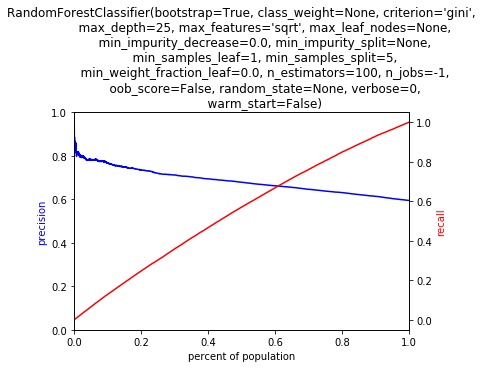

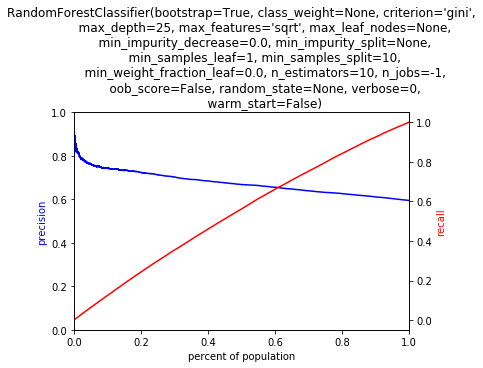

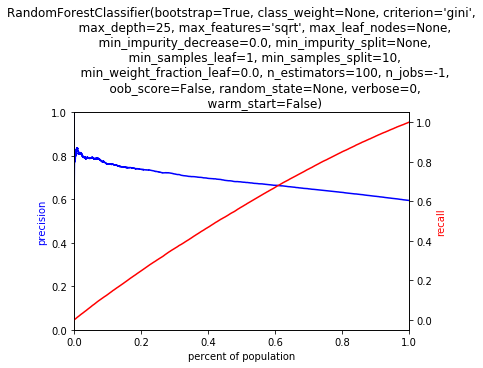

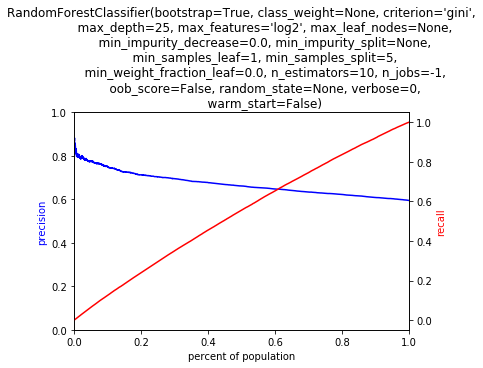

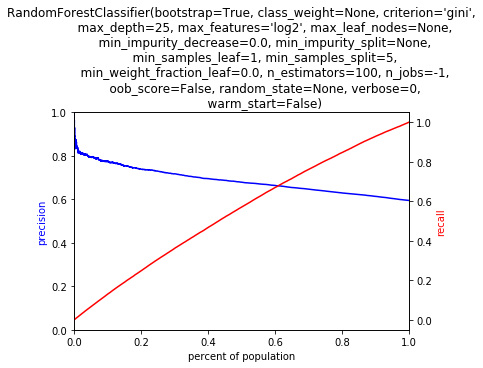

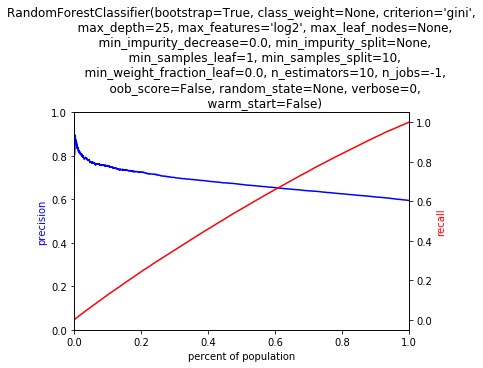

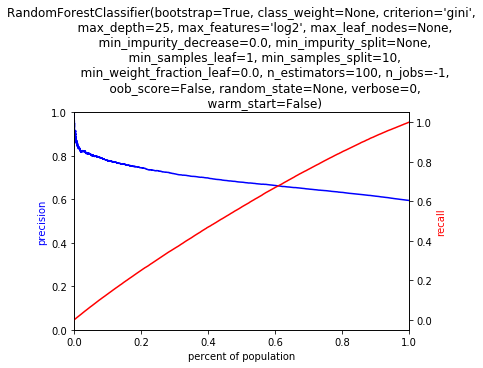

AB


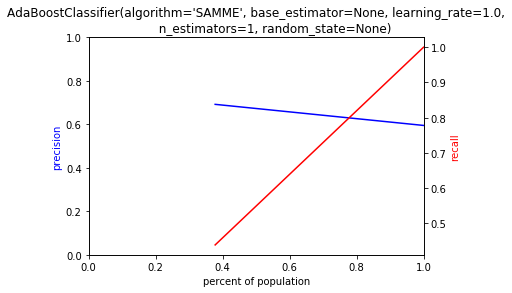

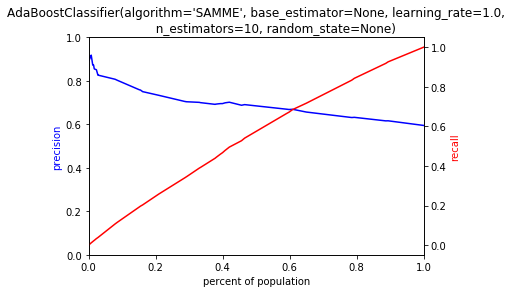

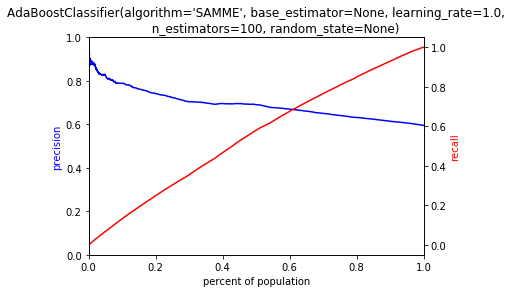

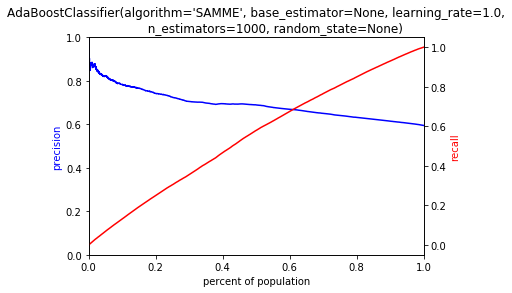

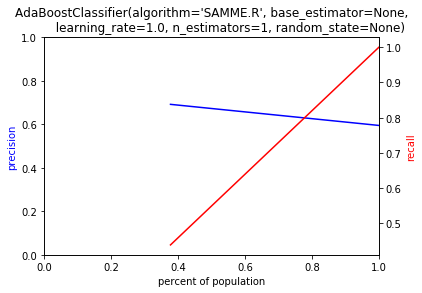

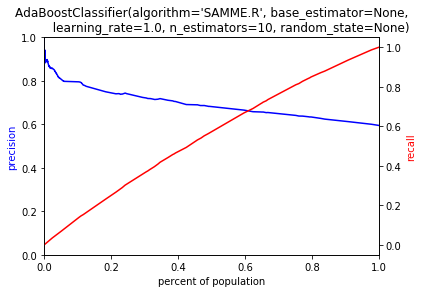

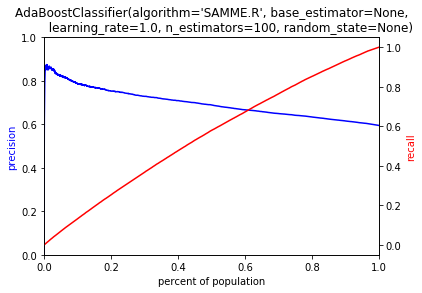

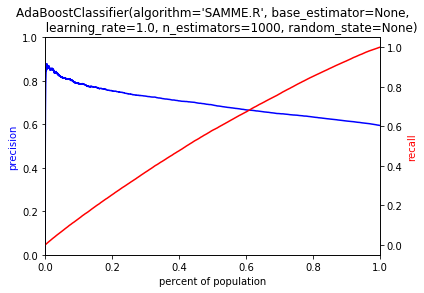

BAG


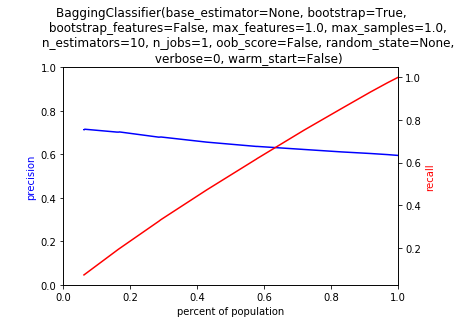

SVM


AttributeError: predict_proba is not available when  probability=False

In [49]:
models = ['LR', 'KNN', 'DT', 'RF', 'AB', 'BAG', 'SVM']
results_df = clfs_loop_temporal(train_sets, test_sets, models)